In [1]:
import numpy as np
from astropy.table import QTable
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from functools import partial
from astropy import constants as c
from pfu_transit.planet_atmosphere_extinction import ExoplanetAtmosphere
from pfu_transit.mask_generation import generate_exoplanet, generate_star
from pfu_transit.photometry_simulation import photometric_observation

In [2]:
datasets = ['Qatar-6 b.txt', 'TrES-2 b.txt', 'TrES-5 b.txt', 'WASP-2 b.txt', 'WASP-52 b.txt']
num = 4

data = np.genfromtxt(f"assets/exoplanet_data/{datasets[num]}", delimiter=',', names=True, skip_header=23)

interp = np.genfromtxt(f"assets/interp_data/"+datasets[num][:-4]+"_interp.txt", delimiter=',', names=True)
interp_dates =  interp['x_interp'] - np.median(interp['x_interp'])
interp_dates_hours = (interp_dates - np.median(interp_dates)) / 60 #REMOVE THIS DIVISION WHEN UNITS ARE FIXED TO HOURS
interp_flux = interp['y_interp']
interp_errs = interp['y_err']

dates = data['DATE']
dates_hours = (dates - np.median(dates)) * 24
flux = data['DIFF']/data['DETREND_2']
errs = data['ERR']

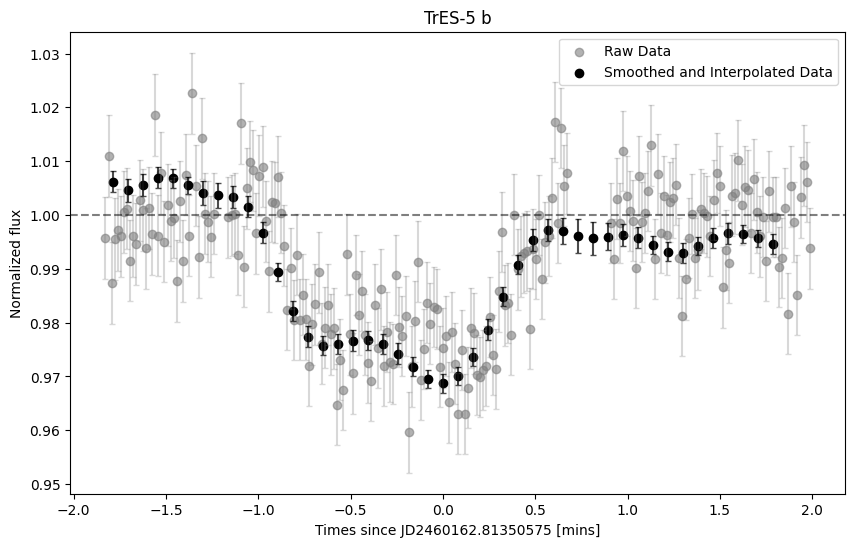

In [3]:
plt.figure(figsize=[10, 6])

plt.scatter(dates_hours, flux, label = 'Raw Data', alpha = .6, c = 'gray')
plt.errorbar(dates_hours, flux, errs, ls = '', alpha = 0.3, capsize=2, c = 'gray')

plt.scatter(interp_dates_hours, interp_flux, label = 'Smoothed and Interpolated Data', c = 'k')
plt.errorbar(interp_dates_hours, interp_flux, interp_errs, ls = '', alpha = 0.7, capsize=2, c = 'k')

plt.xlabel(f'Times since JD{dates[0]} [hours]')
plt.ylabel('Normalized flux')
plt.legend()
plt.title(f"{datasets[2][:-4]}")
plt.axhline(1, ls = '--', c = 'k', alpha = .5)

In [4]:
# Initial guesses/input parameters from database
stellar_radius = 0.79
stellar_temperature = 5000
impact_parameter = 0.6
planet_radius = 1.17
wavelength = 0.6

# Guess these parameters from the plot
transit_duration = 1.3 #hours
midtransit_offset = -0.2

# Calculated parameters for input into model
converted_impact_parameter = impact_parameter*stellar_radius
velocity = 2*stellar_radius*np.sqrt(1-impact_parameter**2)/transit_duration

# Define coarse grid ranges, can be made more fine later at a higher computational cost
Rp_vals  = np.linspace(planet_radius - 0.2, planet_radius + 0.2, 3) # planet radius
b_vals   = stellar_radius*np.linspace(converted_impact_parameter-0.2, converted_impact_parameter+0.2, 3) # impact param
midt_vals  = np.linspace(midtransit_offset-0.05, midtransit_offset+0.05, 3)      # mid_transit_time offsets
vel_vals = np.linspace(velocity-0.2, velocity+0.2, 3)   # velocity

param_grid = [(Rp, b, midt, vel) for Rp in Rp_vals for b in b_vals for midt in midt_vals for vel in vel_vals]
len(param_grid)

81

In [5]:

def evaluate_params(params, t_obs, flux_obs, noise_sigma, star, image_directory = None):
    """
    params: tuple (Rp, b, wavelength, velocity)
    Returns (mse, params)
    """

    Rp, b, mid_t, velocity = params

    try:
        # build star and planet models:

        planet = generate_exoplanet(planet_radius=Rp * (c.R_jup/c.R_sun), b=b, wavelength=wavelength, no_atmosphere=True, planet_oblateness=0, planet_rot_obliquity=0)
        t_model, flux_model = photometric_observation(star= star, planet= planet, velocity=velocity, image_scale=3/2500, step=1, image_directory=image_directory, threadcount=1)

        # normalize
        flux_model = flux_model/np.max(flux_model)
        t_model -= np.median(t_model)
        t_model += mid_t

        if not np.array_equal(t_model, t_obs):
            interp = interp1d(t_model, flux_model, bounds_error=False, fill_value=np.nan)
            flux_model_interp = interp(t_obs)
            # if interpolation produces NaNs - model doesnt cover full observed time - set them to baseline (1)
            nan_mask = np.isnan(flux_model_interp)
            if np.any(nan_mask):
                flux_model_interp[nan_mask] = 1.0
            flux_model = flux_model_interp

        # compute mean squared error
        mse = np.mean((flux_obs -  flux_model)**2)
        return mse, params
    
    except Exception as e:
        print(f'Error evaluating {params}: {e}')
        return np.inf, params


        

In [6]:
star = generate_star(wavelength=wavelength, stellar_oblateness=0, stellar_rot_obliquity=0, stellar_radius=stellar_radius, stellar_temperature=stellar_temperature)

Calculating limb darkening coefficients....


100%|████████████████████████████████████████████████████████████████████████████| 1313/1313 [00:00<00:00, 1362.48it/s]


Creating mask...


100%|█████████████████████████████████████████████████████████████████████████████| 1313/1313 [00:12<00:00, 104.33it/s]


In [7]:
n_workers = min(12, len(param_grid))

results = []
with ThreadPoolExecutor(max_workers=n_workers) as exe:
    futures = [exe.submit(evaluate_params, params, interp_dates_hours, interp_flux, interp_errs, star, None)
               for params in param_grid]

    with tqdm(total=len(futures), desc="Grid search", leave=True) as pbar:
        for f in as_completed(futures):
            results.append(f.result())
            pbar.update(1)

results_sorted = sorted(results, key=lambda x: x[0])
best_mse, best_params = results_sorted[0]
print('Best MSE:', best_mse)
print('Best params:', best_params)

'\nn_workers = min(12, len(param_grid))\n\nresults = []\nwith ThreadPoolExecutor(max_workers=n_workers) as exe:\n    futures = [exe.submit(evaluate_params, params, interp_dates_min, interp_flux, interp_errs, star, None)\n               for params in param_grid]\n\n    with tqdm(total=len(futures), desc="Grid search", leave=True) as pbar:\n        for f in as_completed(futures):\n            results.append(f.result())\n            pbar.update(1)\n\nresults_sorted = sorted(results, key=lambda x: x[0])\nbest_mse, best_params = results_sorted[0]\nprint(\'Best MSE:\', best_mse)\nprint(\'Best params:\', best_params)\n'

In [8]:
best_Rp, best_b, best_midt, best_vel = best_params #(planet_radius, converted_impact_parameter, midtransit_offset, velocity)
planet_best = generate_exoplanet(planet_radius=best_Rp * (c.R_jup/c.R_sun), b=best_b, wavelength=wavelength, planet_oblateness=0, planet_rot_obliquity=0, no_atmosphere=True)
t_best, flux_best = photometric_observation(star, planet_best, velocity=best_vel, image_directory=None)
flux_best = flux_best/np.max(flux_best)
t_best -= np.median(t_best)
t_best += best_midt

100%|██████████████████████████████████████████████████████████████████████████████| 2301/2301 [00:23<00:00, 98.66it/s]


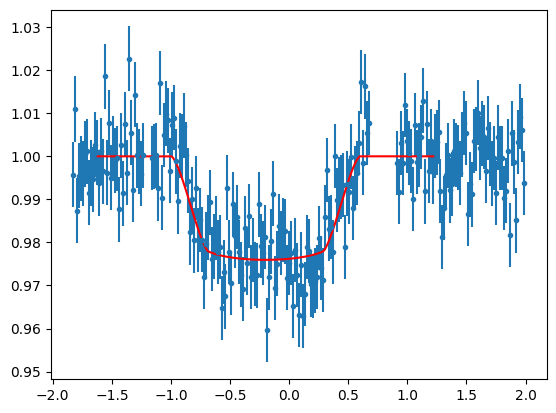

In [10]:
plt.errorbar(dates_hours, flux, yerr=errs, fmt='.')
#plt.errorbar(interp_dates_hours, interp_flux, yerr=interp_errs, fmt='.')
# CAN PLOT INTERPOLATION WHEN FIXED
plt.plot(t_best, flux_best, 'r-')